<a href="https://colab.research.google.com/github/lchen64/C3DfMRI/blob/master/rbm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.2280, 0.2328, 0.9673],
        [0.1944, 0.7836, 0.2214],
        [0.0203, 0.0215, 0.8160],
        [0.2839, 0.8817, 0.9098],
        [0.8383, 0.6874, 0.3628]])


In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [0]:
import torch


class RBM():

    def __init__(self, num_visible, num_hidden, k, learning_rate=1e-3, momentum_coefficient=0.5, weight_decay=1e-4, use_cuda=True):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.learning_rate = learning_rate
        self.momentum_coefficient = momentum_coefficient
        self.weight_decay = weight_decay
        self.use_cuda = use_cuda

        self.weights = torch.randn(num_visible, num_hidden) * 0.1-
        self.visible_bias = torch.ones(num_visible) * 0.5
        self.hidden_bias = torch.zeros(num_hidden)

        self.weights_momentum = torch.zeros(num_visible, num_hidden)
        self.visible_bias_momentum = torch.zeros(num_visible)
        self.hidden_bias_momentum = torch.zeros(num_hidden)

        if self.use_cuda:
            self.weights = self.weights.cuda()
            self.visible_bias = self.visible_bias.cuda()
            self.hidden_bias = self.hidden_bias.cuda()

            self.weights_momentum = self.weights_momentum.cuda()
            self.visible_bias_momentum = self.visible_bias_momentum.cuda()
            self.hidden_bias_momentum = self.hidden_bias_momentum.cuda()

    def sample_hidden(self, visible_probabilities):
        hidden_activations = torch.matmul(visible_probabilities, self.weights) + self.hidden_bias
        hidden_probabilities = self._sigmoid(hidden_activations)
        return hidden_probabilities

    def sample_visible(self, hidden_probabilities):
        visible_activations = torch.matmul(hidden_probabilities, self.weights.t()) + self.visible_bias
        visible_probabilities = self._sigmoid(visible_activations)
        return visible_probabilities

    def contrastive_divergence(self, input_data):
        # Positive phase
        positive_hidden_probabilities = self.sample_hidden(input_data)
        positive_hidden_activations = (positive_hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()
        positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)

        # Negative phase
        hidden_activations = positive_hidden_activations

        for step in range(self.k):
            visible_probabilities = self.sample_visible(hidden_activations)
            hidden_probabilities = self.sample_hidden(visible_probabilities)
            hidden_activations = (hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        negative_associations = torch.matmul(negative_visible_probabilities.t(), negative_hidden_probabilities)

        # Update parameters
        self.weights_momentum *= self.momentum_coefficient
        self.weights_momentum += (positive_associations - negative_associations)

        self.visible_bias_momentum *= self.momentum_coefficient
        self.visible_bias_momentum += torch.sum(input_data - negative_visible_probabilities, dim=0)

        self.hidden_bias_momentum *= self.momentum_coefficient
        self.hidden_bias_momentum += torch.sum(positive_hidden_probabilities - negative_hidden_probabilities, dim=0)

        batch_size = input_data.size(0)

        self.weights += self.weights_momentum * self.learning_rate / batch_size
        self.visible_bias += self.visible_bias_momentum * self.learning_rate / batch_size
        self.hidden_bias += self.hidden_bias_momentum * self.learning_rate / batch_size

        self.weights -= self.weights * self.weight_decay  # L2 weight decay

        # Compute reconstruction error
        error = torch.sum((input_data - negative_visible_probabilities)**2)

        return error

    def _sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def _random_probabilities(self, num):
        random_probabilities = torch.rand(num)

        if self.use_cuda:
            random_probabilities = random_probabilities.cuda()

        return random_probabilities



In [0]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms



########## CONFIGURATION ########## 
BATCH_SIZE = 64
VISIBLE_UNITS = 784  # 28 x 28 images
HIDDEN_UNITS = 784 #128
CD_K = 2
EPOCHS = 10

DATA_FOLDER = ''#'data/mnist'

CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0

if CUDA:
    torch.cuda.set_device(CUDA_DEVICE)


########## LOADING DATASET ##########
print('Loading dataset...')

#train_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=False, transform=torchvision.transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


########## TRAINING RBM ##########
print('Training RBM...')

rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K, use_cuda=CUDA)

for epoch in range(EPOCHS):
    epoch_error = 0.0

    for batch, _ in train_loader:
        batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

        if CUDA:
            batch = batch.cuda()

        batch_error = rbm.contrastive_divergence(batch)

        epoch_error += batch_error

    print('Epoch Error (epoch=%d): %.4f' % (epoch, epoch_error))


########## EXTRACT FEATURES ##########
print('Extracting features...')

train_features = np.zeros((len(train_dataset), HIDDEN_UNITS))
train_labels = np.zeros(len(train_dataset))
test_features = np.zeros((len(test_dataset), HIDDEN_UNITS))
test_labels = np.zeros(len(test_dataset))

for i, (batch, labels) in enumerate(train_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

    if CUDA:
        batch = batch.cuda()

    train_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    train_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

for i, (batch, labels) in enumerate(test_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

    if CUDA:
        batch = batch.cuda()

    test_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    #test_visible[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_visible(batch).cpu().numpy()
    test_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()


########## CLASSIFICATION ##########
print('Classifying...')

clf = LogisticRegression()
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)

print('Result: %d/%d' % (sum(predictions == test_labels), test_labels.shape[0]))


Loading dataset...
Training RBM...
Epoch Error (epoch=0): 3296847.5000
Epoch Error (epoch=1): 2155368.7500
Epoch Error (epoch=2): 1884536.3750
Epoch Error (epoch=3): 1736148.3750
Epoch Error (epoch=4): 1640916.1250
Epoch Error (epoch=5): 1573921.1250
Epoch Error (epoch=6): 1524518.1250
Epoch Error (epoch=7): 1480032.6250
Epoch Error (epoch=8): 1451212.8750
Epoch Error (epoch=9): 1422088.1250
Extracting features...
Classifying...
Result: 9656/10000


In [0]:
import matplotlib.pyplot as plt
#plt.plot(train_features[0], train_labels)
#plt.imshow([train_dataset[1][i].numpy() for i in range(len(train_dataset[1]))])
#train_dataset[1][0]
#print((train_dataset[2][1]))
plt.imshow(train_dataset[2][0].numpy()[0])
plt.show()

NameError: ignored

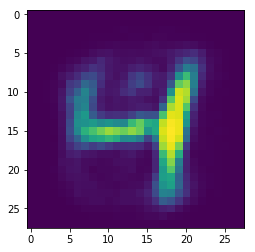

In [0]:
vp = train_dataset[2][0].view(VISIBLE_UNITS)
sh = rbm.sample_hidden(vp)
sv = rbm.sample_visible(sh)
plt.imshow(sv.reshape(28,28))
plt.show()

In [0]:
print(test_labels[0])

7.0
